In [1]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 0s (188 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


In [2]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [3]:
# Load my data
!git clone https://github.com/imaination/efficientDet.git

Cloning into 'efficientDet'...
remote: Enumerating objects: 620, done.
remote: Total 620 (delta 0), reused 0 (delta 0), pack-reused 620
Receiving objects: 100% (620/620), 161.82 MiB | 27.94 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [4]:
spec = model_spec.get('efficientdet_lite0')

In [5]:
# train_data, validation_data, test_data = object_detector.DataLoader.from_csv('gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv')
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('/content/efficientDet/annotations.csv')

In [6]:
model = object_detector.create(train_data, model_spec=spec, batch_size=8, train_whole_model=True, validation_data=validation_data)

Epoch 1/50
30/30 [==============================] - 159s 4s/step - det_loss: 1.6131 - cls_loss: 1.0251 - box_loss: 0.0118 - reg_l2_loss: 0.0630 - loss: 1.6761 - learning_rate: 0.0090 - gradient_norm: 2.0684 - val_det_loss: 1.3091 - val_cls_loss: 0.8113 - val_box_loss: 0.0100 - val_reg_l2_loss: 0.0630 - val_loss: 1.3722
Epoch 2/50
30/30 [==============================] - 121s 4s/step - det_loss: 0.9403 - cls_loss: 0.4894 - box_loss: 0.0090 - reg_l2_loss: 0.0630 - loss: 1.0034 - learning_rate: 0.0100 - gradient_norm: 2.8791 - val_det_loss: 0.8717 - val_cls_loss: 0.4833 - val_box_loss: 0.0078 - val_reg_l2_loss: 0.0631 - val_loss: 0.9347
Epoch 3/50
30/30 [==============================] - 120s 4s/step - det_loss: 0.6893 - cls_loss: 0.3492 - box_loss: 0.0068 - reg_l2_loss: 0.0631 - loss: 0.7523 - learning_rate: 0.0099 - gradient_norm: 2.7924 - val_det_loss: 0.6837 - val_cls_loss: 0.4003 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0631 - val_loss: 0.7468
Epoch 4/50
30/30 [===================

In [7]:
model.evaluate(test_data)

1/1 [==============================] - 8s 8s/step



{'AP': 0.66111565,
 'AP50': 0.94639266,
 'AP75': 0.77139455,
 'AP_/pool': 0.66111565,
 'APl': 0.6690786,
 'APm': 0.6809244,
 'APs': 0.007142857,
 'ARl': 0.73636365,
 'ARm': 0.78205127,
 'ARmax1': 0.43137255,
 'ARmax10': 0.7392157,
 'ARmax100': 0.7588235,
 'ARs': 0.1}

In [8]:
model.export(export_dir='/content/')

In [9]:
model.evaluate_tflite('model.tflite', test_data)

30/30 [==============================] - 85s 3s/step



{'AP': 0.6633134,
 'AP50': 0.9408398,
 'AP75': 0.81702745,
 'AP_/pool': 0.6633134,
 'APl': 0.6675813,
 'APm': 0.6788576,
 'APs': 0.0023809525,
 'ARl': 0.6909091,
 'ARm': 0.73333335,
 'ARmax1': 0.42941177,
 'ARmax10': 0.70392156,
 'ARmax100': 0.7117647,
 'ARs': 0.1}

In [10]:
!pip install opencv-python-headless==4.1.2.30

In [11]:
#@title Load the trained TFLite model and define some visualization functions

import cv2

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

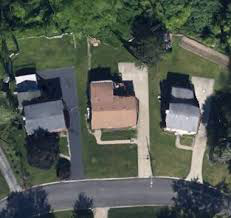

In [23]:
#@title Run object detection and show the detection results

INPUT_IMAGE_URL = "/content/withoutpool.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.5 #@param {type:"number"}

# TEMP_FILE = '/tmp/image.png'
# TEMP_FILE = '/content/efficientDet/image_subset/00061.jpg'
TEMP_FILE = INPUT_IMAGE_URL
# print(TEMP_FILE)
im = Image.open(TEMP_FILE)
# !wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
# im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)